Get all packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from functions import *
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle
import glob
import cftime
import netCDF4 as nc

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/mposternack/conda-envs/my-npl-tensor/share/proj failed
2025-05-07 18:13:38.542984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 18:13:38.707961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746663218.763504   10561 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746663218.777709   10561 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746663218.873

Load dataset from the directory discussed with Kirstin -- 500 years (monthwise data)

In [5]:
with open("wwb-saved-variables.pickle", "rb") as f:
    wwbs_saved, lat_max_saved, myfiles_saved = pickle.load(f)

var_dict = wwbs_saved

center = var_dict["center"]
data_locations = xr.Dataset({
    "center_time": (("event",), center[0]),
    "center_lon": (("event",), center[1]),
    "zonal_extent": (("event",), var_dict["zonal_extent"]),
    "strength": (("event",), var_dict["strength"]),
    "duration": (("event",), var_dict["duration"]),
})
data_locations

<xarray.Dataset> Size: 5kB
Dimensions:       (event: 133)
Dimensions without coordinates: event
Data variables:
    center_time   (event) float64 1kB 1.496e+04 1.702e+04 ... 1.506e+04
    center_lon    (event) float64 1kB 158.0 122.0 129.0 ... 137.0 144.0 185.0
    zonal_extent  (event) float64 1kB 40.0 17.0 17.0 24.0 ... 20.0 26.0 18.0
    strength      (event) float64 1kB 30.6 19.68 19.67 ... 8.371 7.803 6.82
    duration      (event) float64 1kB 24.0 10.0 14.0 9.0 ... 7.0 6.0 7.0 12.0

In [96]:
slices = []
strengths = []
durations = []
times = []  

file_indices = (wwbs_saved['center'][0] // 365).astype(int)
time_indices = ((wwbs_saved['center'][0] % 365) * 4).astype(int)

for i in range(len(file_indices)):
    file_idx = file_indices[i]
    time_idx = time_indices[i]

    curr_file = nc.Dataset(myfiles_saved[file_idx])
    PS = curr_file["PS"]
    time_var = curr_file["time"]
    lats = curr_file["lat"][:]
    lons = curr_file["lon"][:]

    ps = np.asarray(PS[time_idx, :, :])
    time_value = nc.num2date(time_var[time_idx], time_var.units) 
    times.append(time_value)

    center_lon = wwbs_saved["center"][1][i].item()
    zonal_extent = wwbs_saved["zonal_extent"][i].item()
    strength = wwbs_saved["strength"][i].item()
    duration = wwbs_saved["duration"][i].item()

    lat_mask = np.logical_and(lats >= -20, lats <= 20)
    selected_lats = lats[lat_mask]

    """
    # if we are defining by zonal extent
    lon_min = center_lon - zonal_extent / 2
    lon_max = center_lon + zonal_extent / 2
    lon_mask = np.logical_and(lons >= lon_min, lons <= lon_max)
    """
    
    # if we want whole pacific 
    lon_mask = np.logical_and(lons >= 100, lons <= 195)
    selected_lons = lons[lon_mask]
    

    ps_sliced = ps[np.ix_(lat_mask, lon_mask)]

    da = xr.DataArray(ps_sliced,
                      coords={"lat": selected_lats, "lon": selected_lons},
                      dims=["lat", "lon"])
    da = da.expand_dims(event=[i])

    slices.append(da)
    strengths.append(strength)
    durations.append(duration)

    curr_file.close()

combined = xr.concat(slices, dim="event")
combined["strength"] = ("event", strengths)
combined["duration"] = ("event", durations)
combined["time"] = ("event", times)  

combined.to_netcdf("ps_with_wwb_from_files_pacific_ocean.nc")


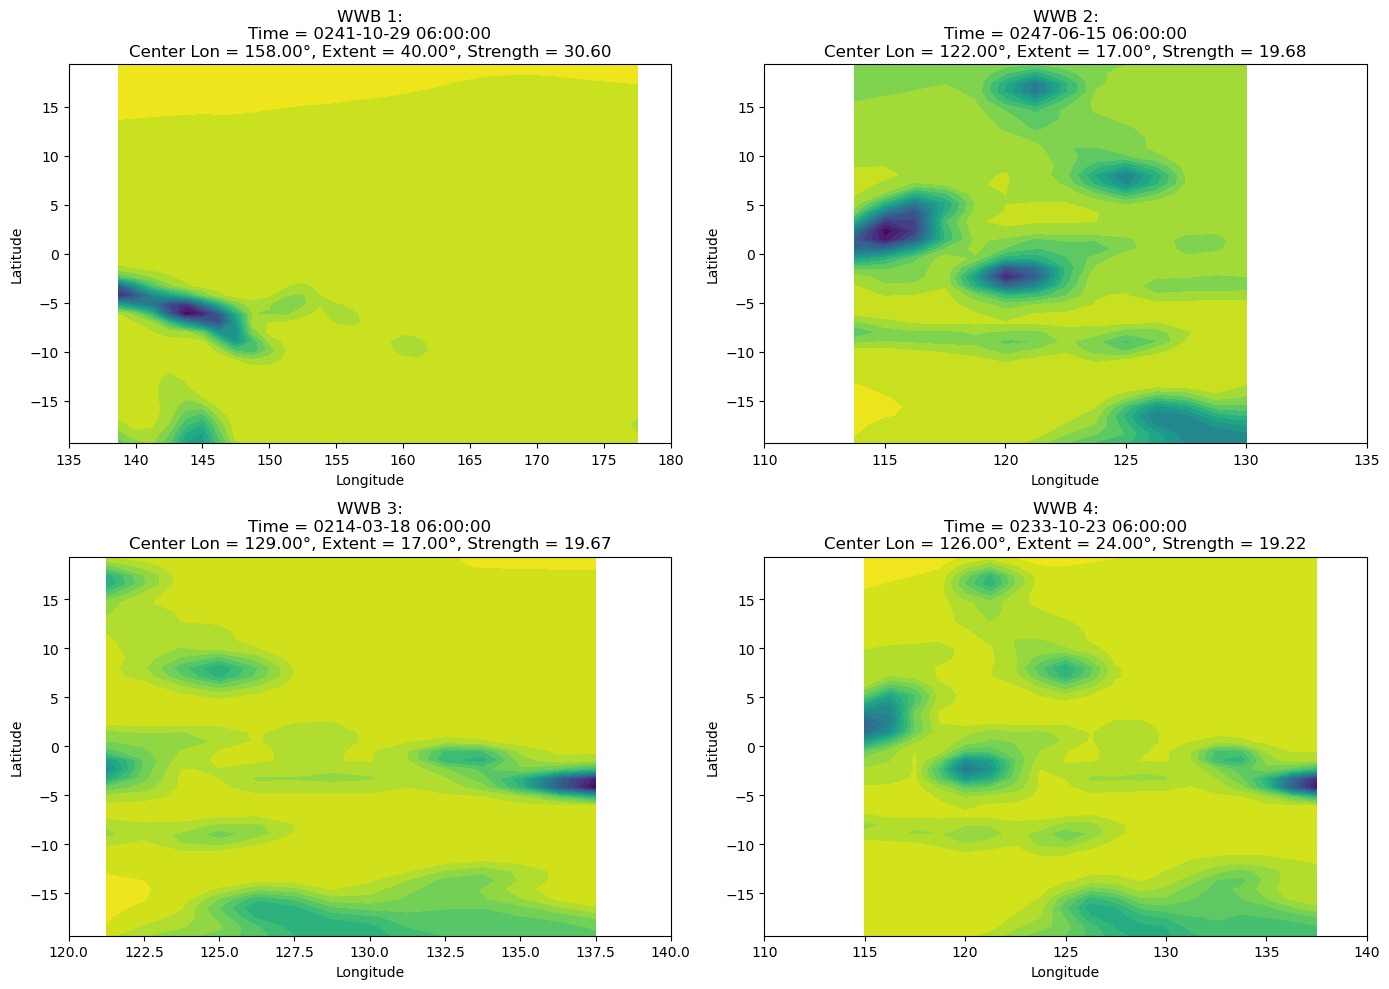

In [90]:
psls_with_wwb = xr.open_dataset("ps_with_wwb_from_files_zonal_extent.nc")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx in range(4):
    ax = axs[idx]
    first_psl = psls_with_wwb['__xarray_dataarray_variable__'].isel(event=idx)
    WWB_time = psls_with_wwb['time'].isel(event=idx).values
    WWB_center_lon = wwbs_saved["center"][1][idx].item()
    WWB_zonal_extent = wwbs_saved["zonal_extent"][idx].item()
    WWB_strength = psls_with_wwb['strength'].isel(event=idx).values

    c = ax.contourf(first_psl.lon, first_psl.lat, first_psl, levels=20, cmap='viridis')
    ax.set_title(
        f"WWB {idx+1}:\n"
        f"Time = {WWB_time}\n"
        f"Center Lon = {WWB_center_lon:.2f}°, Extent = {WWB_zonal_extent:.2f}°, "
        f"Strength = {WWB_strength:.2f}"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

axs[0].set_xlim(135, 180)
axs[1].set_xlim(110, 135)
axs[2].set_xlim(120, 140)
axs[3].set_xlim(110, 140)

plt.tight_layout()
plt.show()


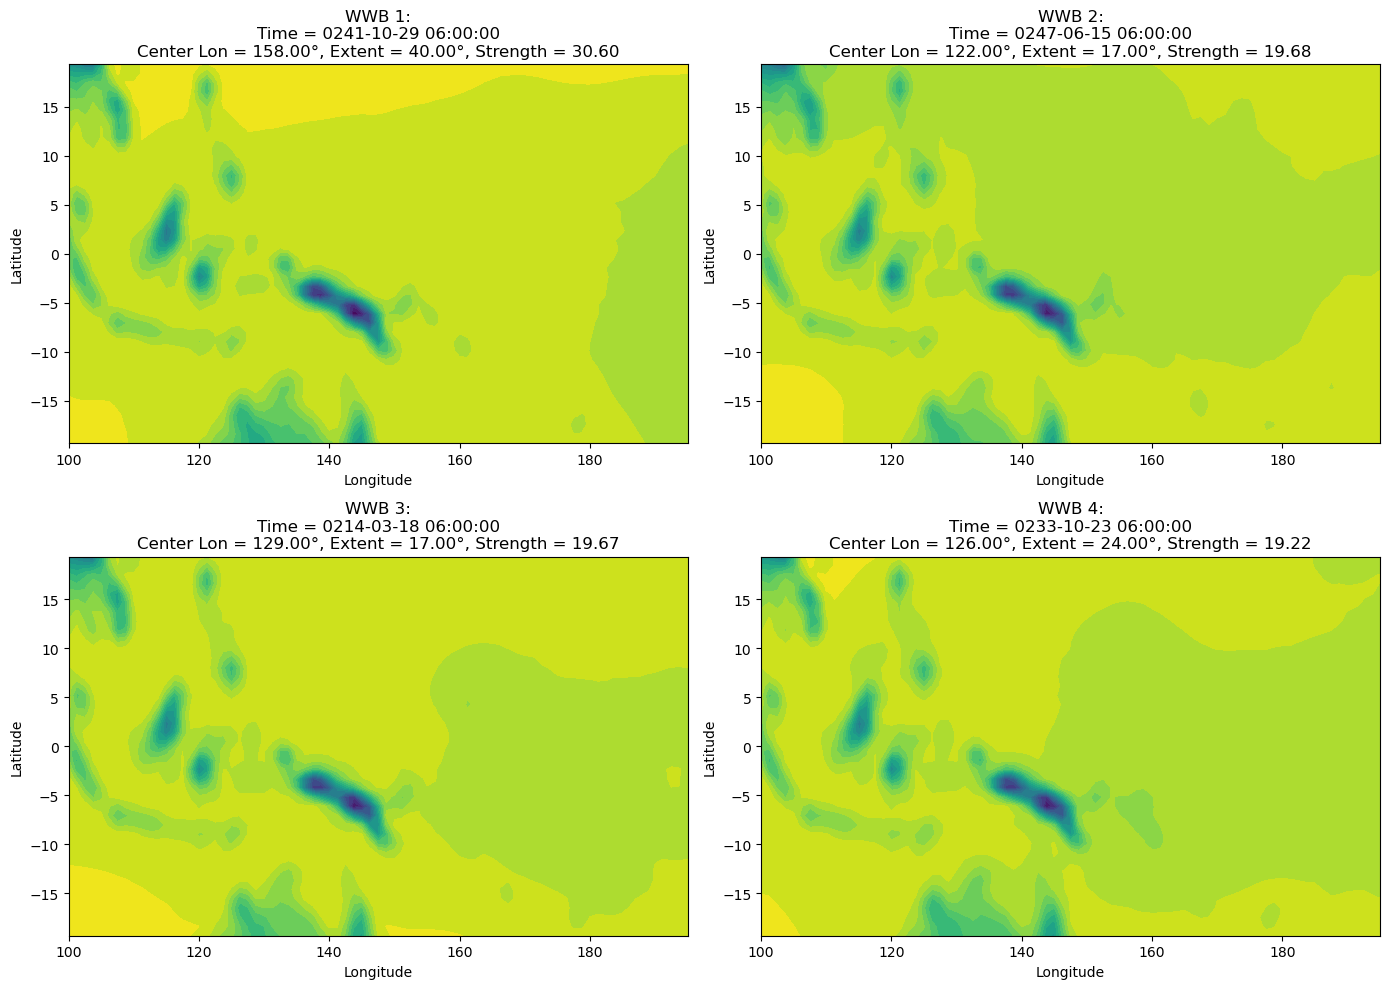

In [98]:
psls_with_wwb_pacific = xr.open_dataset("ps_with_wwb_from_files_pacific_ocean.nc")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx in range(4):
    ax = axs[idx]
    first_psl = psls_with_wwb_pacific['__xarray_dataarray_variable__'].isel(event=idx)
    WWB_time = psls_with_wwb_pacific['time'].isel(event=idx).values
    WWB_center_lon = wwbs_saved["center"][1][idx].item()
    WWB_zonal_extent = wwbs_saved["zonal_extent"][idx].item()
    WWB_strength = psls_with_wwb_pacific['strength'].isel(event=idx).values

    c = ax.contourf(first_psl.lon, first_psl.lat, first_psl,  levels=20, cmap='viridis')
    ax.set_title(
        f"WWB {idx+1}:\n"
        f"Time = {WWB_time}\n"
        f"Center Lon = {WWB_center_lon:.2f}°, Extent = {WWB_zonal_extent:.2f}°, "
        f"Strength = {WWB_strength:.2f}"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


In [84]:
def deseasonalize(data):
    
    monthly_avg = data.groupby("time.month").mean()
    deseasonalized_data = data.groupby("time.month") - monthly_avg
    return deseasonalized_data

In [42]:
deseasonalized_data  =  deseasonalize(psls_with_wwb)

In [43]:
deseasonalized_data

<xarray.Dataset> Size: 3MB
Dimensions:   (lat: 42, lon: 115, event: 133)
Coordinates:
  * lat       (lat) float64 336B -19.32 -18.38 -17.43 ... 17.43 18.38 19.32
  * lon       (lon) float64 920B 38.75 40.0 41.25 42.5 ... 191.2 192.5 193.8
  * event     (event) int64 1kB 0 1 2 3 4 5 6 7 ... 126 127 128 129 130 131 132
    time      (event) object 1kB 0241-12-28 06:00:00 ... 0242-04-09 06:00:00
    strength  (event) float64 1kB 30.6 19.68 19.67 19.22 ... 8.371 7.803 6.82
    duration  (event) float64 1kB 24.0 10.0 14.0 9.0 29.0 ... 7.0 6.0 7.0 12.0
    month     (event) int64 1kB 12 8 5 12 1 4 11 4 11 9 ... 3 2 4 4 3 10 2 7 4 4
Data variables:
    PSL       (event, lat, lon) float32 3MB nan nan nan nan ... 0.0 0.0 0.0 0.0

In [44]:
time_length, lat_length, lon_length = deseasonalized_data["PSL"].values.shape
scaler = StandardScaler()
X_standardized_flat = scaler.fit_transform(deseasonalized_data["PSL"].values.reshape(-1, 1))
X_standardized = X_standardized_flat.reshape(time_length, lat_length, lon_length, 1)

In [45]:
psl_filled = np.nan_to_num(X_standardized, nan=0.0)

In [46]:
psl_filled.shape

(133, 42, 115, 1)

In [47]:
lat_length = 48
long_length = 128
pad_lat = (lat_length - 42) 
pad_lon = (long_length - 115) 

pad_top = pad_lat // 2
pad_bottom = pad_lat - pad_top
pad_left = pad_lon // 2
pad_right = pad_lon - pad_left

psl_padded = np.pad(
    psl_filled,
    pad_width=((0, 0), (pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
    mode='constant',
    constant_values=0
)

psl_padded.shape

(133, 48, 128, 1)

In [48]:
x_train, x_test = train_test_split(
    psl_padded, test_size=0.2, 
)

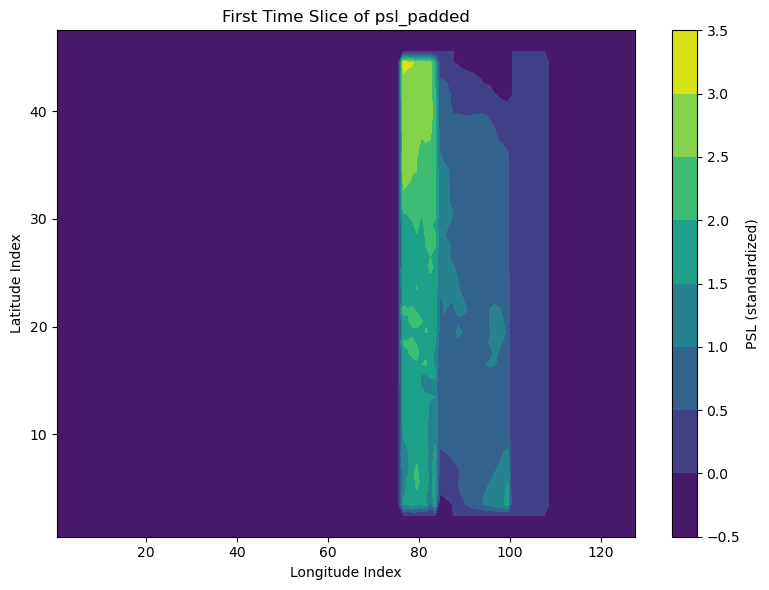

In [69]:
plt.figure(figsize=(8, 6))
plt.contourf(psl_padded[0, :, :, 0], cmap='viridis', origin='lower')
plt.colorbar(label='PSL (standardized)')
plt.title('First Time Slice of psl_padded')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.tight_layout()
plt.show()


Run autoencoder

In [50]:
pool_size = (2,2)  # default
conv_size = (3,3)
rounds = [16,8,8,8]
epochs = 1000  
learning_rate = 1e-4 
batch_size=128


In [51]:
input_img = keras.Input(shape=(lat_length, long_length, 1))

x = input_img
#encoding
for i in rounds:
    x = layers.Conv2D(i, conv_size, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size, padding='same')(x)

encoded = x

#decoding
for i in reversed(rounds):
    x = layers.Conv2D(i, conv_size, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(pool_size)(x)

x = layers.Conv2D(1, conv_size, activation='tanh', padding='same')(x) # final result

decoded = x


In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

Initial Error

In [53]:
print("x_train shape:", x_train.shape)
print("x_train dtype:", x_train.dtype)
print("x_train sample shape:", x_train[0].shape)


x_train shape: (106, 48, 128, 1)
x_train dtype: float32
x_train sample shape: (48, 128, 1)


In [54]:
autoencoder.evaluate(x_train, x_train, batch_size=batch_size, verbose=0)

0.12239067256450653

Fit autoencoder using epochs defined above

In [55]:
autoencoder.fit(x_train, x_train,
                epochs=epochs, 
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping, TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1224 - val_loss: 0.1281
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1223 - val_loss: 0.1280
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.1221 - val_loss: 0.1279
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - loss: 0.1220 - val_loss: 0.1278
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1219 - val_loss: 0.1277
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1219 - val_loss: 0.1276
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.1218 - val_loss: 0.1276
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1217 - val_loss: 0.1275
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1216 - val_loss: 0.1274
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1216 - val_loss: 0.1274
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1215 - val_loss: 0.1273
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - 

Predict and depict images

In [56]:
decoded_imgs = autoencoder.predict(x_test)
scaler = StandardScaler()
decoded_flat = scaler.fit_transform(decoded_imgs.reshape(-1, 1))
decoded_standardized = decoded_flat.reshape(int(time_length*.2)+1, lat_length, long_length, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


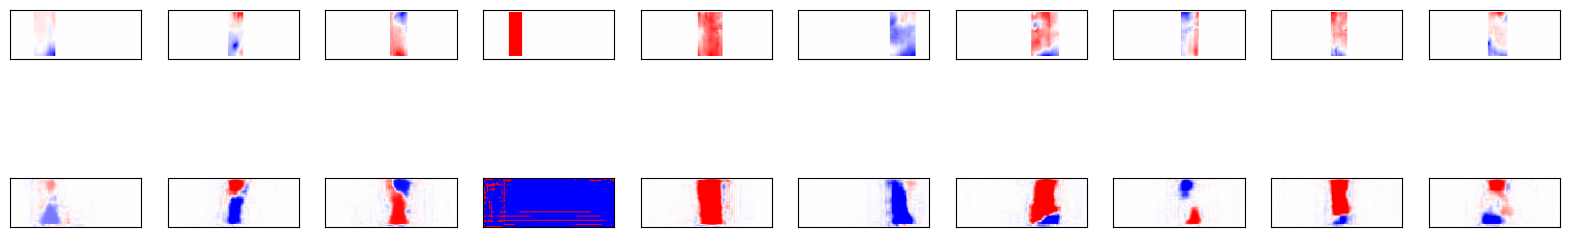

In [57]:
n = 10

fig=plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    max_value = np.max(np.abs(x_test[i]))

    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(lat_length, long_length), cmap='bwr', vmin=-max_value, vmax=max_value)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_standardized[i].reshape(lat_length, long_length),cmap='bwr', vmin=-max_value, vmax=max_value)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show(block=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


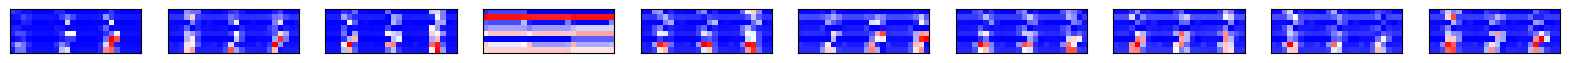

In [58]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

fig=plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    # Display latent space
    ax = plt.subplot(1, n, i)
    flat = encoded_imgs[i].reshape(-1, encoded_imgs.shape[-1])
    plt.imshow(flat.T, cmap='bwr')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Compare sizes for scale

Confirm latent space ~10%

In [59]:
print("Latent space shape:", encoder.output_shape)

Latent space shape: (None, 3, 8, 8)


In [60]:
original_size = np.prod(x_test.shape[1:])  
latent_size = np.prod(encoded_imgs.shape[1:]) 
compression_ratio = latent_size / original_size

print(f"Compression ratio: {compression_ratio:.2%}")

Compression ratio: 3.12%


Now we cluster using kMeans

In [61]:
latent_vectors = encoded_imgs.reshape((encoded_imgs.shape[0], -1))

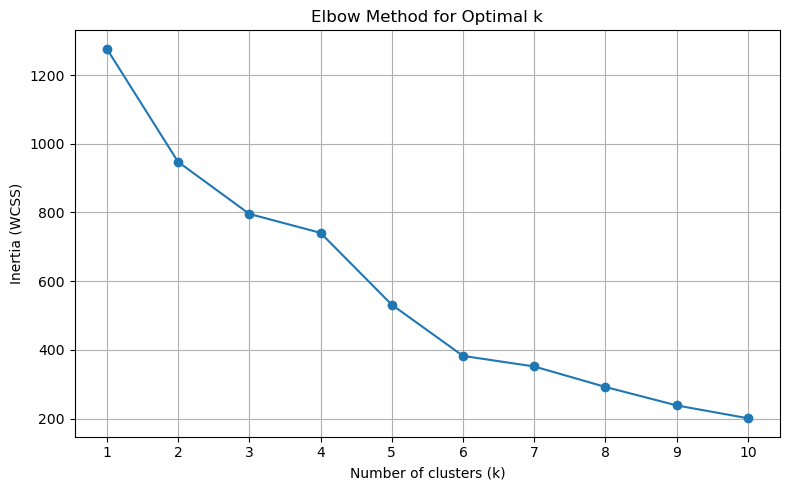

In [62]:
k_values = range(1, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(latent_vectors)
    inertias.append(kmeans.inertia_) 

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
ideal_k = 6
kmeans = KMeans(n_clusters=ideal_k)
cluster_labels = kmeans.fit_predict(latent_vectors) 

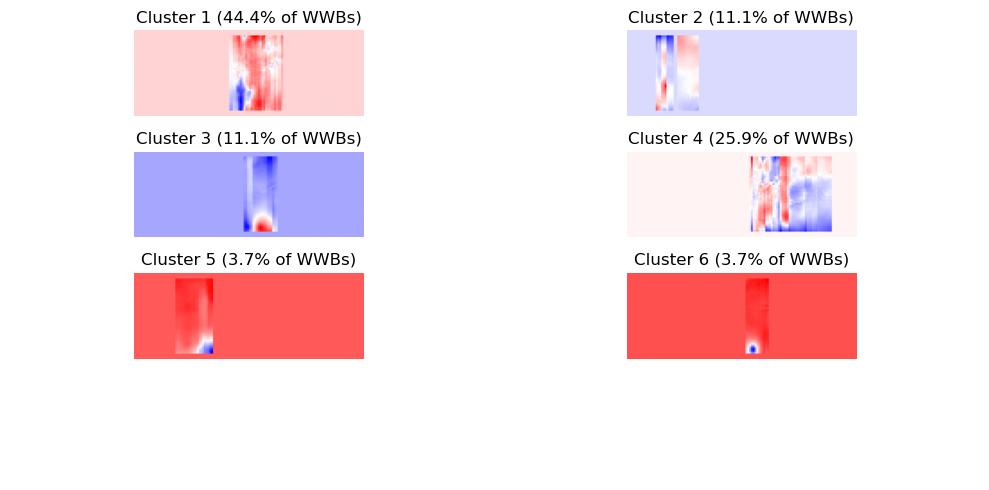

In [66]:
total_events = len(cluster_labels)
cluster_images = []
percentages = []

for k in range(ideal_k):
    indices = np.where(cluster_labels == k)[0]
    imgs = x_test[indices]
    cluster_images.append(imgs)
    percent = 100 * len(indices) / total_events
    percentages.append(percent)

avg_images = [np.mean(imgs, axis=0).squeeze() for imgs in cluster_images]

ncols = 2
nrows = int(np.ceil((ideal_k + 1) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 5))
axs = axs.flatten()

for i, (avg_img, pct) in enumerate(zip(avg_images, percentages)):
    axs[i].imshow(avg_img, cmap='bwr')
    axs[i].set_title(f"Cluster {i+1} ({pct:.1f}% of WWBs)")
    axs[i].axis('off')

for j in range(len(avg_images), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
